In [1]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
import torchvision.transforms as transforms
import torchvision
import torchvision.transforms.functional as TF

import PIL
from collections import OrderedDict
from tqdm.auto import tqdm
import os
import json
import requests
from io import BytesIO

from dataset import ImageCoco, MyCollate
import config
from model import ImageCaptioningModel
from engine import fit, validate, model_train



from utils import SaveBestModel, EarlyStopping, LrScheduler

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.crossattention.q_attn.weight', 'h.4.crossattention.c_attn.weight', 'h.11.crossattention.q_attn.weight', 'h.3.crossattention.c_attn.weight', 'h.5.crossattention.masked_bias', 'h.5.crossattention.c_proj.weight', 'h.8.crossattention.masked_bias', 'h.1.crossattention.q_attn.weight', 'h.10.crossattention.q_attn.weight', 'h.10.crossattention.c_proj.bias', 'h.10.crossattention.c_proj.weight', 'h.2.crossattention.bias', 'h.7.crossattention.c_proj.weight', 'h.5.crossattention.bias', 'h.8.crossattention.c_proj.weight', 'h.8.crossattention.q_attn.weight', 'h.11.crossattention.bias', 'h.0.crossattention.masked_bias', 'h.7.ln_cross_attn.weight', 'h.3.crossattention.c_proj.bias', 'h.3.crossattention.q_attn.weight', 'h.9.crossattention.masked_bias', 'h.4.crossattenti

In [2]:
transform_train = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_val = transforms.Compose(
    [   
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

In [3]:
train_dataset = ImageCoco(root_directory='../datasets/coco/train2014/', 
                    annFile='../datasets/coco/annotations/captions_train2014.json', 
                    tokenizer=config.TOKENIZER,
                    transform=transform_train)

val_dataset = ImageCoco(root_directory='../datasets/coco/val2014/', 
                    annFile='../datasets/coco/annotations/captions_val2014.json', 
                    tokenizer=config.TOKENIZER,
                    transform=transform_val)

In [4]:
train_dataloader = DataLoader(dataset=train_dataset, 
                              shuffle=True,
                              num_workers=8, 
                              pin_memory=True,
                              batch_size=config.TRAIN_BATCH_SIZE, 
                              collate_fn=MyCollate(config.TOKENIZER.pad_token_id, 
                                                   config.TOKENIZER, 
                                                   max_len=config.MAX_LEN))


test_dataloader = DataLoader(dataset=val_dataset, 
                             shuffle=True, 
                             num_workers=8, 
                             pin_memory=True,
                             batch_size=config.VALID_BATCH_SIZE, 
                             collate_fn=MyCollate(config.TOKENIZER.pad_token_id, 
                                                  config.TOKENIZER, 
                                                  max_len=config.MAX_LEN)
                            )

In [5]:
images, sents, attention = iter(test_dataloader).next()

In [6]:
images.shape, sents[0], attention.shape

(torch.Size([64, 3, 224, 224]),
 tensor([50256,    32, 17254,   309, 43602,   317, 12672,  2751,  5161,   317,
           309, 34571,  1797, 46433,    13, 50256, 50257, 50257]),
 torch.Size([64, 18]))

In [7]:
target_vocab_len = len(config.TOKENIZER)
model = ImageCaptioningModel(target_vocab_len, 
                             embedding_size=768,  
                             num_layers=config.NUM_LAYERS, 
                             heads=config.NUM_HEADS, 
                             dropout=config.DECODER_DROPOUT, 
                             feedforward_dim=3072, 
                             max_len=config.MAX_LEN).to("cuda")

print(f"Model paramters here : {sum(p.numel() for p in model.parameters())}")
pad_idx = config.TOKENIZER.pad_token_id

loss_fn = torch.nn.CrossEntropyLoss(ignore_index=pad_idx)
optimizer = torch.optim.AdamW(model.parameters(), lr=config.LEARNING_RATE, weight_decay=1e-6, amsgrad=True)

Model paramters here : 173968720


In [10]:
optimizer.load_state_dict(torch.load("bestmodel.bin")["optimizer_state_dict"])
model.load_state_dict(torch.load("bestmodel.bin")["model_state_dict"])
# optimizer.param_groups[0]['lr'] = config.LEARNING_RATE

<All keys matched successfully>

In [11]:
# model, train_loss, val_loss = model_train(model,
#                                           train_dataloader,
#                                           test_dataloader, 
#                                           config.EPOCHS,
#                                           config.LEARNING_RATE, 
#                                           loss_fn,
#                                           optimizer=optimizer,
#                                           early_stop=True)

In [12]:
import torch
import PIL
import numpy
import requests
from io import BytesIO 
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt


def caption_image(model, image_link, max_len=100):
    model.eval()
    with torch.no_grad():
        if image_link.startswith('http'):
            res = requests.get(image_link)
            img = PIL.Image.open(BytesIO(res.content))
        else:
            img = PIL.Image.open(image_link).convert()

        plt.imshow(img)
        encoder_input = transform_val(img)

        encoder_input = encoder_input.unsqueeze(0).to(device)
        encoder_output = model.image_encoder(encoder_input).unsqueeze(1).to(device)
        tgt_tokens = torch.ones(1, 1 ).fill_(config.TOKENIZER.bos_token_id).type(torch.long).to(device)

        for i in range(max_len - 1):
            tgt_mask = model.generate_square_subsequent_mask(tgt_tokens.size(1))
            tgt_attentions = torch.ones_like(tgt_tokens).to(device)
            out = model.decoder(input_ids=tgt_tokens, 
                                encoder_hidden_states=encoder_output, 
                                attention_mask=tgt_attentions)['logits']

            next_word = torch.argmax(out[:,-1,:], dim=-1)
            next_word = next_word.item()
            if next_word == config.TOKENIZER.eos_token_id:
                break
            decoder_input_masked = torch.ones(1,1).type_as(tgt_tokens.data).fill_(next_word).to(device)
            tgt_tokens = torch.cat((tgt_tokens, decoder_input_masked), dim=1)

        decoded_sentence =  config.TOKENIZER.decode(tgt_tokens[0])
        return decoded_sentence.replace(config.TOKENIZER.bos_token, '').capitalize()

'A man riding a motorcycle down a street next to a court yard.'

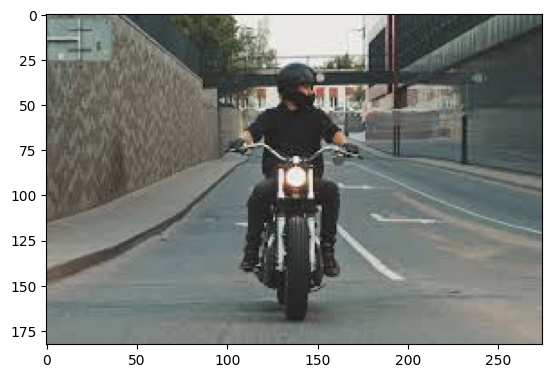

In [13]:
caption_image(model, "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTbXCZekmVIYYckvLvddC5HLmtSYcE8vwVDcbRpHYyyng&usqp=CAU&ec=48665699")

'A group of people shopping at an outdoor market.'

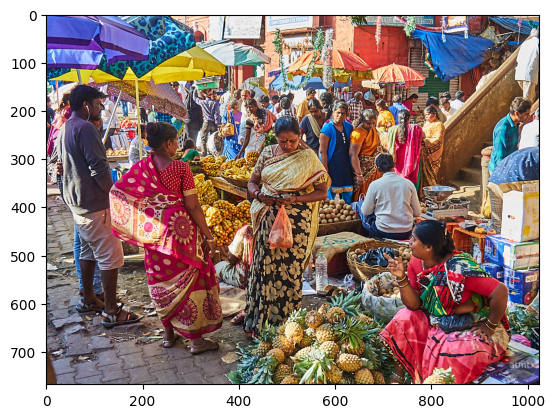

In [14]:
destination = "https://photos.smugmug.com/Blog/Creative-Commons-2/i-6bVVfbh/0/4ce6768f/O/bangalore-india-2018-kr-market-exterior.jpg"

caption_image(model, destination)

'A wooden chair is in a room next to a window.'

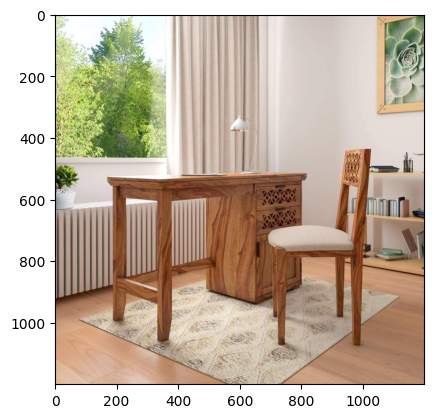

In [15]:
destination = "https://ganpatiarts.com/wp-content/uploads/2020/09/7-2-e1641692721445.jpg"

caption_image(model, destination)

In [16]:
with open("../datasets/coco/annotations/captions_train2014.json") as file:
    f = json.load(file)

'A man is standing in a red phone booth.'

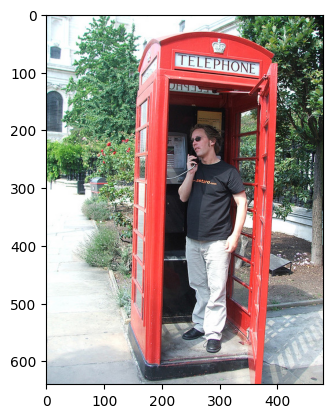

In [17]:
caption_image(model, f['images'][2]['coco_url'])